In [44]:
import random
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
import itertools
import pickle
import math
from wordcloud import WordCloud, ImageColorGenerator
sns.set()

In [45]:
# Read in the dataframe
import pickle
import pandas as pd
import numpy as np

df = pd.read_pickle("script_df.pkl")
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id
0,1,1,Dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1
1,1,2,McGonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1
2,1,3,Dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1
3,1,4,McGonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1
4,1,5,Dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1


# Cleaning the dataframe:

In [88]:
# All the movie titles in correct order
move_titles = ["Harry Potter and the Philosopher's Stone","Harry Potter and the Chamber of Secrets",
              "Harry Potter and the Prisoner of Azkaban","Harry Potter and the Goblet of Fire",
              "Harry Potter and the Order of the Phoenix","Harry Potter and the Half-Blood Prince",
              "Harry Potter and the Deathly Hallows – Part 1","Harry Potter and the Deathly Hallows – Part 2"]
move_titles_short = [move_titles[i].split("Harry Potter and the ", 1)[1] for i in range(len(move_titles))]

In [47]:
# Lets first fix the characters So they all have lower_case letters
df['character'] = df['character'].str.lower()

In [48]:
# df[df.sentence != ''].groupby('character').size()
# sentence_count = df[df.sentence != ''].groupby('character').size()
# sentence_count_limit = sentence_count[sentence_count > 2]

In [49]:
# some general last fixing 
# mapping_voldemort = {'voldemort':['voldermort','tom riddle']}

In [50]:
# Todo, go through all the characters and map the correct names and remove those that do not make sense.

# Enrich the dataframe with sentiment analysis

### Create dictionary of character and movie sentences

In [51]:
# Add new column to dataframe that include the tokenized sentences
# Function to calculate the sentiment of tokenized list
def tokenize(text):
    #toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    return(lem_words)

stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [56]:
# Lets combine all sentences of characters into a dictionary

char_sentences = dict()
for character in df.character.unique():
    text = tokenize(df.sentence[df.character == character].str.cat(sep=' '))
    char_sentences[character] = text
    
# Lets combine all sentences for each movie into a dictionary
movie_sentences = dict()
for movie in df.movie_nr.unique():
    text = tokenize(df.sentence[df.movie_nr == movie].str.cat(sep=' '))
    movie_sentences[movie] = text
    
# maybe have dictionary that has the key movie, that has the key of character and and the value as sentence

In [58]:
# Read in the sentiment text file
import csv
sentiments = {}
with open('data/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

In [59]:
# Function to calculate the average sentiment for each characters 
def sentiment(freqdist,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None

In [73]:
# Get average sentiment for all sentences of character
char_sentiment = {}
for char in char_sentences:
    sentiment_for_char = sentiment(nltk.FreqDist(char_sentences[char]))
    if sentiment_for_char:
        char_sentiment[char] = sentiment_for_char
        
# Get average sentiment for all sentences of character
movie_sentiment = {}
for movie in movie_sentences:
    sentiment_for_movie = sentiment(nltk.FreqDist(movie_sentences[movie]))
    if sentiment_for_movie:
        movie_sentiment[movie] = sentiment_for_movie

In [63]:
# Function to calculate the sentiment of tokenized list
def token_getsent(text):
    #lets toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    
    # Get the sentiment score
    return(sentiment(nltk.FreqDist(lem_words)))
    

# Add the sentiment for all scenes and sentences
df['sentence_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)
df['scene_desc_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)

# lets add the average sentence sentiment for each scene_id
df['avg_scene_sent'] = df.groupby(['scene_id'])['sentence_sent'].transform('mean')
df['avg_scene_desc_sent'] = df.groupby(['scene_id'])['scene_desc_sent'].transform('mean')

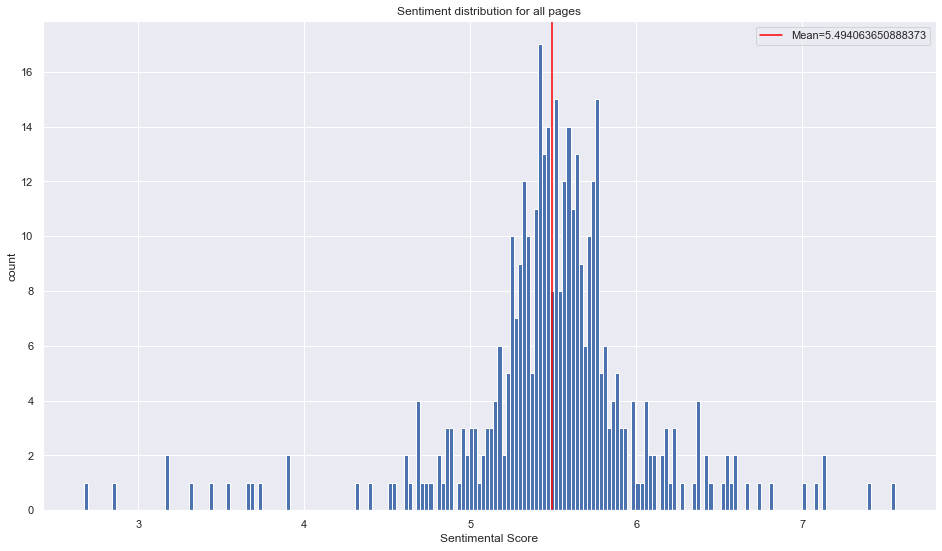

In [64]:
#Create a histogram of all character's associated page-sentiments.
import numpy as np 

plt.figure(figsize=(16,9))
plt.hist(char_sentiment.values(),bins=200)
sent_mean = np.mean((list(char_sentiment.values())))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

## General statistics about the script data set:

### Creating count for various properties of the scripts

In [ ]:
# Sentence count, that is the highset sentence number for each movie
sentence_count = []
for movie in df.movie_nr.unique():
    sentence_count.append(df.sentence_number[df.movie_nr == movie].max())
sentence_count

# Scene count
scene_count = []
for movie in df.movie_nr.unique():
    scene_count.append(df.scene_id[df.movie_nr == movie].max())
scene_count

# Character count
character_count = []
for movie in df.movie_nr.unique():
    character_count.append(len(df.character[df.movie_nr == movie].unique()))
character_count

In [92]:
movie_sentiment.values()

dict_values([5.540098146128683, 5.473864754975388, 5.487554876354544, 5.5837273276904344, 5.48824194653872, 5.575484618626217, 5.511474152856792, 5.463909198113211])

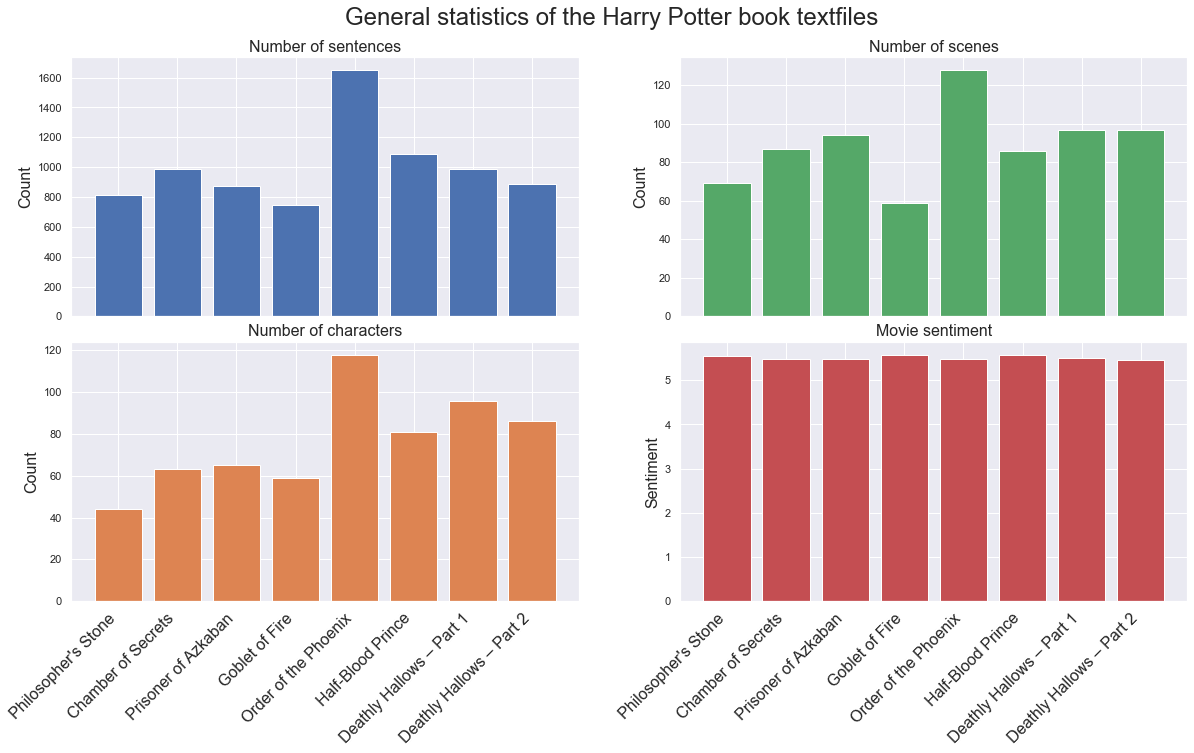

In [93]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(20,10), gridspec_kw={'hspace': 0.1})

palette = itertools.cycle(sns.color_palette())

axes[0][0].bar(move_titles_short, sentence_count, width = 0.8, color=next(palette))
axes[0][0].set_title('Number of sentences', fontsize=16)
axes[0][0].set_ylabel('Count', fontsize=16)

axes[1][0].bar(move_titles_short, character_count, width = 0.8, color=next(palette))
axes[1][0].set_title('Number of characters', fontsize=16)
axes[1][0].set_ylabel('Count', fontsize=16)

axes[0][1].bar(move_titles_short, scene_count, width = 0.8, color=next(palette))
axes[0][1].set_title('Number of scenes', fontsize=16)
axes[0][1].set_ylabel('Count', fontsize=16)

axes[1][1].bar(move_titles_short, movie_sentiment.values(), width = 0.8, color=next(palette))
axes[1][1].set_title('Movie sentiment', fontsize=16)
axes[1][1].set_ylabel('Sentiment', fontsize=16)

# Set the rotation and horizontal alignment of the x tick labels
plt.setp(axes[1][0].get_xticklabels(), rotation=45, ha="right", fontsize=16);
plt.setp(axes[1][1].get_xticklabels(), rotation=45, ha="right", fontsize=16);

# Set plot title
plt.suptitle('General statistics of the Harry Potter book textfiles', fontsize=24, y = 0.95);

In [ ]:
# Look at the top speaking characters

# Create character connections based on how many times the interact in the movies

In [106]:
# lets create connection between characters 

# for movie in df.movie_nr:
# movie = 1
# df_names = df['character'].unique()
# df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr.unique():
    print(f'Going through movie {movie}')
    df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()
    for scene in df_store:
    #     print("Scene length:",len(scene))
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
    #             print(scene[idx],scene[idx2])
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

{('dumbledore', 'mcgonagall'): 5,
 ('dumbledore', 'hagrid'): 8,
 ('dumbledore', 'petunia'): 1,
 ('dumbledore', 'dudley'): 1,
 ('dumbledore', 'vernon'): 1,
 ('dumbledore', 'harry'): 51,
 ('mcgonagall', 'hagrid'): 2,
 ('mcgonagall', 'petunia'): 1,
 ('mcgonagall', 'dudley'): 1,
 ('mcgonagall', 'vernon'): 1,
 ('mcgonagall', 'harry'): 19,
 ('hagrid', 'petunia'): 2,
 ('hagrid', 'dudley'): 2,
 ('hagrid', 'vernon'): 2,
 ('hagrid', 'harry'): 46,
 ('petunia', 'dudley'): 4,
 ('petunia', 'vernon'): 7,
 ('petunia', 'harry'): 5,
 ('dudley', 'vernon'): 6,
 ('dudley', 'harry'): 9,
 ('vernon', 'harry'): 7,
 ('dudley', 'snake'): 1,
 ('dudley', 'man'): 1,
 ('vernon', 'snake'): 1,
 ('vernon', 'man'): 1,
 ('harry', 'snake'): 1,
 ('harry', 'man'): 7,
 ('snake', 'man'): 1,
 ('snake', 'petunia'): 1,
 ('man', 'petunia'): 1,
 ('harry', 'all'): 4,
 ('vernon', 'all'): 1,
 ('hagrid', 'all'): 3,
 ('petunia', 'all'): 1,
 ('all', 'dudley'): 1,
 ('harry', 'tom'): 2,
 ('harry', 'witch'): 1,
 ('harry', 'quirrell'): 5,
 

In [138]:
top_10 = sorted(scene_interactions, key=scene_interactions.get, reverse=True)[:10]

# scene_interactions[top_10]
# top_10
# top_list = []
# for pair in top_10:
#     top_list.append(scene_interactions[pair])

dict_you_want = { your_key: scene_interactions[your_key] for your_key in top_10 }
dict_you_want

{('ron', 'harry'): 227,
 ('harry', 'hermione'): 210,
 ('ron', 'hermione'): 178,
 ('dumbledore', 'harry'): 51,
 ('hagrid', 'harry'): 46,
 ('neville', 'harry'): 35,
 ('neville', 'ron'): 29,
 ('harry', 'ginny'): 29,
 ('neville', 'hermione'): 27,
 ('snape', 'harry'): 27}

### Trying different method of interaction

In [ ]:
# lets create connection between characters 

# for movie in df.movie_nr:
# movie = 1
# df_names = df['character'].unique()
# df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr.unique():
    print(f'Going through movie {movie}')
    df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()
    for scene in df_store:
    #     print("Scene length:",len(scene))
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
    #             print(scene[idx],scene[idx2])
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

In [132]:
dict(sorted(scene_interactions.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])

AttributeError: 'dict' object has no attribute 'iteritems'

In [107]:
dict(sorted(scene_interactions.items(), key=lambda x: x[1]['score'], reverse=True)[:2])

TypeError: 'int' object is not subscriptable

In [104]:
df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()
df_store

scene_id  movie_nr
1         1           [dumbledore, mcgonagall, hagrid, petunia, dudl...
2         1                                           [petunia, vernon]
3         1                [dudley, vernon, harry, snake, man, petunia]
4         1                                    [petunia, harry, vernon]
5         1                                     [vernon, dudley, harry]
                                            ...                        
65        1                                [harry, quirrell, voldemort]
66        1                                         [dumbledore, harry]
67        1                                      [harry, ron, hermione]
68        1           [dumbledore, students, draco, harry, hermione,...
69        1                                   [hagrid, hermione, harry]
Name: character, Length: 66, dtype: object

In [102]:
df_store = df[df.movie_nr == movie].groupby(['scene_desc','movie_nr'])['character'].unique()

scene_desc                                                                                                                                                                                                                     movie_nr
(Cheering)                                                                                                                                                                                                                     1                             [mcgonagall]
A couple look at Hagrid.                                                                                                                                                                                                       1                                 [hagrid]
A girl, HERMIONE GRANGER, with bushy brown hair appears at the doorway.                                                                                                                                                        1            

In [96]:
# con_scene_desc = dict()
# for movie in df.movie_nr:
movie = 1
# df_names = df['character'].unique()
df_store = df[df.movie_nr == movie].groupby(['scene_desc','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr:
    df_movie = df[df.movie_nr == movie]
    for scene in df_scene:
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

{('hermione', 'ron'): 35,
 ('quirrell', 'hagrid'): 1,
 ('quirrell', 'harry'): 5,
 ('hagrid', 'harry'): 25,
 ('ron', 'mcgonagall'): 6,
 ('harry', 'ron'): 48,
 ('man', 'snape'): 1,
 ('man', 'ron'): 1,
 ('man', 'hagrid'): 1,
 ('snape', 'ron'): 3,
 ('snape', 'hagrid'): 1,
 ('ron', 'hagrid'): 8,
 ('woman', 'ron'): 2,
 ('woman', 'harry'): 1,
 ('harry', 'hermione'): 34,
 ('dumbledore', 'harry'): 3,
 ('woman', 'percy'): 1,
 ('woman', 'girl'): 1,
 ('percy', 'girl'): 3,
 ('percy', 'ron'): 4,
 ('girl', 'ron'): 3,
 ('flitwick', 'harry'): 2,
 ('flitwick', 'ron'): 1,
 ('mcgonagall', 'quirrell'): 2,
 ('mcgonagall', 'nick'): 1,
 ('mcgonagall', 'harry'): 5,
 ('quirrell', 'nick'): 1,
 ('quirrell', 'ron'): 2,
 ('nick', 'ron'): 3,
 ('nick', 'harry'): 1,
 ('draco', 'harry'): 8,
 ('snake', 'harry'): 1,
 ('dudley', 'harry'): 6,
 ('dumbledore', 'mcgonagall'): 5,
 ('dumbledore', 'hermione'): 2,
 ('dumbledore', 'ron'): 1,
 ('mcgonagall', 'hermione'): 4,
 ('filch', 'hermione'): 2,
 ('filch', 'ron'): 2,
 ('filch'

In [99]:
df[df.sentence != ''].character.unique()

array(['dumbledore', 'mcgonagall', 'hagrid', 'petunia', 'dudley',
       'vernon', 'harry', 'snake', 'man', 'all', 'tom', 'witch',
       'quirrell', 'boy', 'goblin', 'griphook', 'ollivander',
       'trainmaster', 'george', 'fred', 'ron', 'woman', 'frog',
       'hermione', 'neville', 'draco', 'seamus', 'percy', 'nick', 'girl',
       'snape', 'hooch', 'class', 'students', 'filch', 'oliver',
       'flitwick', 'oiiver', 'lee', 'gryffindors', 'flint', 'crowd',
       'firenze', 'voldemort', 'uncle vernon', 'aunt petunia', 'dobby',
       'mr. mason', 'same scene - later', "closeup - harry's trunk 13b",
       "insert - fred's foot 13c", 'mrs. weasley', 'ginny', 'mr. weasley',
       'harry /ron/fred/george', 'mr. borgin', 'lucius malfoy',
       'aged witch', 'short man', 'gilderoy lockhart', 'guard',
       'harry /ron', 'albus dumbledore', 'professor sprout',
       'penelope clearwater', 'nearly headless nick', 'colin',
       'dean thomas', "at work and it's entirely your",
       

In [ ]:
df[['sentence','movie_nr']][df.character == 'RON/HERMIONE/MRS. WEASLEY']

In [ ]:
# Skoða sentiment á setningum komið

# SKoða sentiment á scenes komið 

# SKoða sentiment sérstakra karaktera  komið

# Skoða tengst karaktera m.v. scene eða röðun (fyrir og eftir), ef character kemur fyrir og eftir þá tala þeir sama t.d.

# Create wordclous out of sentences with the outlines of the characters

# Create a quiz where you get a sentence from character and guess who it was.

# Wordclouds of characters

In [151]:
#Todo: 
# Make worlcloud for 5 most occuring characters from each house and plot there figure and worldcloud.

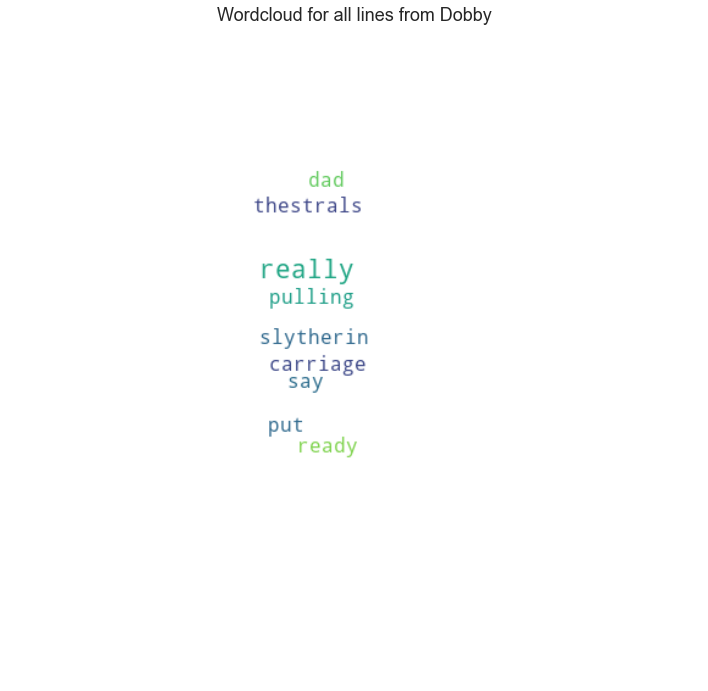

In [152]:
from os import path
from PIL import Image
import os

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
hp_mask = np.array(Image.open(path.join(d, "data/char_images/dobby.jpg")))

# Define the settings and input to the wordclouds - DC
wordcloud_all_books = WordCloud(background_color='white',   
                         width=1000,
                         max_words=2000,
                         height=1000, 
                         colormap="viridis",
                         mask = hp_mask,
                         random_state = 42
                         #contour_width=1, 
                         #contour_color='steelblue'
                        ).generate_from_frequencies(harry_freq)

plt.figure(figsize=(10,10))

plt.imshow(wordcloud_all_books, interpolation='bilinear')
plt.title("Wordcloud for all lines from Dobby", fontsize=18)
plt.axis("off")
plt.tight_layout()

In [125]:
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sentence_sent,scene_desc_sent,avg_scene_sent,avg_scene_desc_sent
0,1,1,dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1,5.740,5.740,5.506538,5.506538
1,1,2,mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1,6.685,6.685,5.506538,5.506538
2,1,3,dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1,4.635,4.635,5.506538,5.506538
3,1,4,mcgonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1,6.240,6.240,5.506538,5.506538
4,1,5,dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1,6.040,6.040,5.506538,5.506538


In [126]:
# function to plot moving average 

def m_avg(values,N): # takes in the values and the N of average (how many values to use)
    size = len(values)
    if size-N < 2:
        return(f'Short list or N too big.')
    else:
        cumsum, moving_aves = [0], []

        for i, x in enumerate(values, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                
                # add the the average vector
                moving_aves.append(moving_ave)
    return(moving_aves)

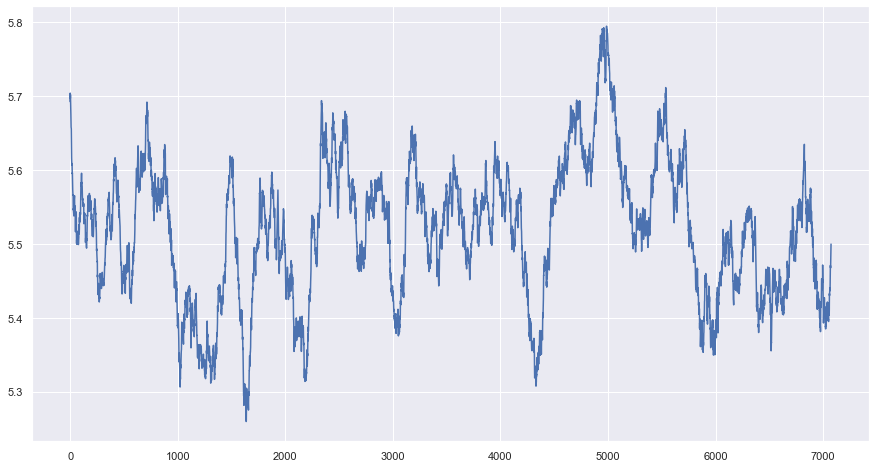

In [160]:
# m_avg(df.sent_sentence.dropna(),10)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(m_avg(df.sentence_sent.dropna(),150))

In [166]:
df[df.character == 'harry']['sentence']

21                                     Yes, Aunt Petunia.
24                                     Yes, Uncle Vernon.
36                                           He's asleep!
38      Sorry about him. He doesn't understand what it...
39      Can you...hear me? {The snake nods} It's just....
                              ...                        
7969                       Because it answers to another.
7970    When he killed Snape, he thought the wand woul...
7971    It was Draco who disarmed Dumbledore that nigh...
7973                                    It answers to me.
7977                      Well, it wasn’t boring, was it?
Name: sentence, Length: 1995, dtype: object

In [172]:
df['character'][df.movie_nr == 2].value_counts()[:50].index.tolist() # get 20 most occuring characters 

['harry',
 'ron',
 'hermione',
 'gilderoy lockhart',
 'tom riddle',
 'dumbledore',
 'hagrid',
 'lucius malfoy',
 'dobby',
 'draco',
 'uncle vernon',
 'mrs. weasley',
 'snape',
 'moaning myrtle',
 'mr. weasley',
 'filch',
 'wood',
 'aragog',
 'harry /ron',
 'voice',
 'madam pomfrey',
 'ginny',
 'percy',
 'dudley',
 'professor sprout',
 'neville',
 'seamus',
 'colin',
 'mr. borgin',
 'fudge',
 'george',
 'ernie',
 'young hagrid',
 'hannah',
 'fred',
 'aunt petunia',
 'justin finch-fletchley',
 'same scene - later',
 'dean thomas',
 'sorting hat',
 'flint',
 'albus dumbledore',
 'penelope clearwater',
 'harry /ron/hermione',
 'the chamber of secrets has been opened',
 'back to scene',
 'dissolve',
 "at work and it's entirely your",
 'nearly headless nick',
 'lucious malfoy']

In [247]:
# Todo, finish up the moving average plot, set different colors on different movies
df[df.character ==  'aragog']['sentence']

1573    You do not come from the forest. Your hearts b...
1575    Hagrid has never sent men into our hollow before.
1577    That's a lie! Hagrid never opend the Chamber o...
1579    The monster was born in the castle. I came fro...
1582    We do not speak of it! It is an ancient creatu...
1584    I never saw any part of the castle but the cup...
1587    Go? I think not. My sons and daughters do not ...
2559    You do not come from the forest. Your hearts b...
2561    Hagrid has never sent men into our hollow before.
2563    That's a lie! Hagrid never opend the Chamber o...
2565    The monster was born in the castle. I came fro...
2568    We do not speak of it! It is an ancient creatu...
2570    I never saw any part of the castle but the cup...
2573    Go? I think not. My sons and daughters do not ...
Name: sentence, dtype: object

In [243]:
sentiments['die']

1.74